In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Train test split
from sklearn.model_selection import train_test_split

# Feature normalisation
from sklearn.preprocessing import StandardScaler

# Model hyperparameter tuning
from sklearn.model_selection import GridSearchCV 
from sklearn.utils.class_weight import compute_sample_weight

# Models
import xgboost as xgb

# Model Evaluation Section -----
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
df = pd.read_csv("../datasets/water_fe.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

In [3]:
# drivers = df[['quantity','longitude_imputation','latitude_imputation','gps_height','waterpoint_type_group',
#              'extraction_type_class','construction_decade','amount_tsh','payment_type']]

# drivers = df[['longitude_imputation','latitude_imputation','quantity','gps_height','extraction_type_class',
#              'waterpoint_type_group','payment_type','funder_grouped','amount_tsh','source_type','population_original','age']]

# drivers = df[['longitude_imputation','latitude_imputation','quantity','extraction_type_class','gps_height','age','waterpoint_type_group',
#              'population_original','payment_type','source_type','amount_tsh','funder_grouped','installer_grouped']]

drivers = df[['longitude_imputation','latitude_imputation','quantity','extraction_type_class','gps_height','age',
              'waterpoint_type_group','population_original','payment_type','source_type','funder_grouped',
              'basin','installer_grouped','management','water_quality','public_meeting']]
target = df['outcome']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(drivers, 
                                                    target,
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=42)

In [5]:
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train)
Xs_test = scaler.fit_transform(X_test)

___
# <ins>Model Building<ins>

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [7]:
class_weights = compute_sample_weight('balanced', y_train)

In [8]:
# XGBoost Classification model initialisation
xgboost_clf = xgb.XGBClassifier(seed=42)

# XGBoost Classification model's parameter grid
f_xgboost_search = GridSearchCV(xgboost_clf,
                            param_grid={'seed': [42],
                                        'max_depth': [10,15,20,25],
                                        'colsample_bytree': [0.75],
                                        'subsample': [0.5],
                                        'gamma': [0,1],
                                        'learning_rate': [0.01,0.1],
                                        'objective' : ['multi:softmax']
                                        },
                            scoring='accuracy',
                           verbose=3)

# Run fit with all sets of parameters
f_xgboost_search.fit(Xs_train, y_train,sample_weight=class_weights)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END colsample_bytree=0.75, gamma=0, learning_rate=0.01, max_depth=10, objective=multi:softmax, seed=42, subsample=0.5;, score=0.724 total time=   5.8s
[CV 2/5] END colsample_bytree=0.75, gamma=0, learning_rate=0.01, max_depth=10, objective=multi:softmax, seed=42, subsample=0.5;, score=0.717 total time=   5.4s
[CV 3/5] END colsample_bytree=0.75, gamma=0, learning_rate=0.01, max_depth=10, objective=multi:softmax, seed=42, subsample=0.5;, score=0.730 total time=   5.9s
[CV 4/5] END colsample_bytree=0.75, gamma=0, learning_rate=0.01, max_depth=10, objective=multi:softmax, seed=42, subsample=0.5;, score=0.720 total time=   5.5s
[CV 5/5] END colsample_bytree=0.75, gamma=0, learning_rate=0.01, max_depth=10, objective=multi:softmax, seed=42, subsample=0.5;, score=0.721 total time=   5.9s
[CV 1/5] END colsample_bytree=0.75, gamma=0, learning_rate=0.01, max_depth=15, objective=multi:softmax, seed=42, subsample=0.5;, score=0.76

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     r

In [9]:
print("Best parameter for XGBoost Classification ", f_xgboost_search.best_params_)
print("Accuracy: ", f_xgboost_search.best_score_, "\n")

Best parameter for XGBoost Classification  {'colsample_bytree': 0.75, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 25, 'objective': 'multi:softmax', 'seed': 42, 'subsample': 0.5}
Accuracy:  0.7904040404040404 



              precision    recall  f1-score   support

           0       0.81      0.85      0.83      6452
           1       0.44      0.39      0.42       863
           2       0.82      0.78      0.80      4565

    accuracy                           0.79     11880
   macro avg       0.69      0.67      0.68     11880
weighted avg       0.79      0.79      0.79     11880



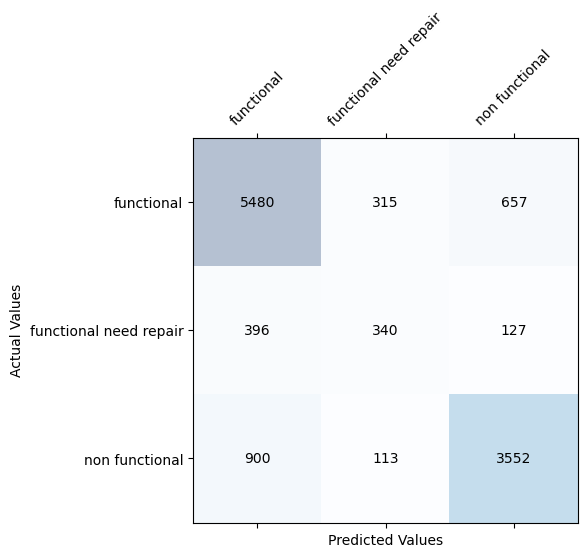

In [10]:
# Fit XGBoost Classification with the best parameter 
xgboost = xgb.XGBClassifier(**f_xgboost_search.best_params_)

xgboost.fit(Xs_train, y_train,sample_weight=class_weights)
y_pred =xgboost.predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["functional","functional need repair","non functional"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

In [11]:
models = []
models.append(("XGBoost", xgboost))

# Test options and evaluation metric
num_folds = 5
num_instances = len(Xs_train)
scoring = "accuracy"
results = []
names = []

for name, model in models:
    kf = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, Xs_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
print("5-Fold cross-validation accuracy score for the training data for all the classifiers")

for name, cv_results in zip(names, results):
    print("%-15s: %.6f (%.6f)" % (name, cv_results.mean(), cv_results.std()))

5-Fold cross-validation accuracy score for the training data for all the classifiers
XGBoost        : 0.800021 (0.002052)


---
## Final Model using entire dataset

In [12]:
# Initialise XGBoost classifier with the best parameter
xgboost_model = xgb.XGBClassifier(**f_xgboost_search.best_params_)

# Normalise data
Xns = scaler.fit_transform(drivers)

# Train XGBoost classifier with the entire dataset
xgboost_model.fit(Xns, target)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.75,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=25, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [13]:
# Save the model
import pickle

# Dump and save the Random Forest Classifier model
with open("XGBoostClassifier.pickle", "wb") as f:
    pickle.dump(xgboost_model, f)